In [1]:
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
from pprint import pprint

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

import re
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import GridSearchCV


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline


C:\Users\computer\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## I. DATA LOAD

In [2]:
train = pd.read_json('data/train.json', encoding = 'UTF-8')

COPY

In [3]:
df = train.copy()

print(df.shape)
df.tail(2)

(39774, 3)


,cuisine,id,ingredients
39772,chinese,41882,"[boneless chicken skinless thigh, minced garli..."
39773,mexican,2362,"[green chile, jalapeno chilies, onions, ground..."


#### 1) Count

In [4]:
df.count()

cuisine        39774
id             39774
ingredients    39774
dtype: int64

#### 2) Number of NaNs for each column

In [5]:
df.isnull().sum()

cuisine        0
id             0
ingredients    0
dtype: int64

#### 3) Cuisine Types

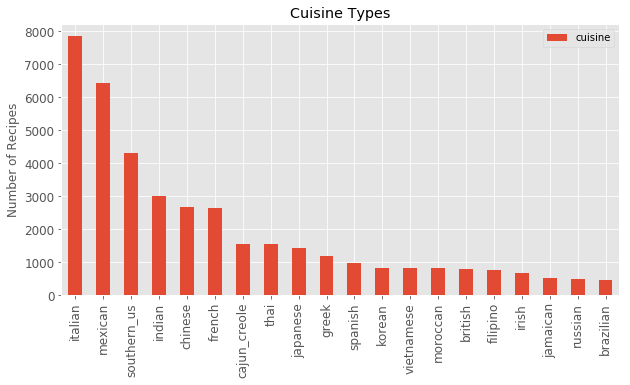

In [6]:
# cuisine type

plt.style.use('ggplot')
df.cuisine.value_counts().plot(kind = 'bar',
                              title='Cuisine Types',
                              figsize=(10,5),
                              legend=True,
                              fontsize=12)
plt.ylabel("Number of Recipes", fontsize=12)
plt.show()

#### 4) Ingredients Types

In [7]:

bag_of_ingredients = [Counter(ingredient) for ingredient in df.ingredients]


sum_of_ingredients = sum(bag_of_ingredients, Counter())

########################################################################################



# dict -> list -> dataframe
sum_of_ingredients_dict = dict(sum_of_ingredients)
sum_of_ingredients_list = list(sum_of_ingredients_dict.items())

ingredients_df = pd.DataFrame(sum_of_ingredients_list)
ingredients_df.columns = ['ingredient', 'count']
ingredients_df.tail(2)

print(' ingredient.'.format(len(ingredients_df)))

 ingredient.


In [9]:
ingredients_df.head(20)

,ingredient,count
0,romaine lettuce,270
1,black olives,229
2,grape tomatoes,228
3,garlic,7380
4,pepper,4438
5,purple onion,1896
6,seasoning,137
7,garbanzo beans,148
8,feta cheese crumbles,358
9,plain flour,154


## III. Pre-processing

In [10]:
def pre_processing_(recipe):
    
    wnl = WordNetLemmatizer()
    
    # 1. lower
    recipe = [str.lower(ingredient) for ingredient in recipe]
    
    
    def delete_brand_(ingredient):
        
        
        ingredient = re.sub("country crock|i can't believe it's not butter!|bertolli|oreo|hellmann's"
                            , '', ingredient)
        ingredient = re.sub("red gold|hidden valley|original ranch|frank's|redhot|lipton", '', ingredient)
        ingredient = re.sub("recipe secrets|eggland's best|hidden valley|best foods|knorr|land o lakes"
                            , '', ingredient)
        ingredient = re.sub("sargento|johnsonville|breyers|diamond crystal|taco bell|bacardi", '', ingredient)
        ingredient = re.sub("mccormick|crystal farms|yoplait|mazola|new york style panetini", '', ingredient)
        ingredient = re.sub("ragu|soy vay|tabasco|truvía|crescent recipe creations|spice islands", '', ingredient)
        ingredient = re.sub("wish-bone|honeysuckle white|pasta sides|fiesta sides", '', ingredient)
        ingredient = re.sub("veri veri teriyaki|artisan blends|home originals|greek yogurt|original ranch"
                            , '', ingredient)
        ingredient = re.sub("jonshonville", '', ingredient)

        
        ingredient = re.sub("old el paso|pillsbury|progresso|betty crocker|green giant|hellmannâ€", '', ingredient)

        # 'oscar mayer deli fresh smoked' 
        ingredient = re.sub("oscar mayer deli fresh smoked", '', ingredient)
        
        return ingredient
    
    
    def delete_state_(ingredient):
    
        ingredient = re.sub('frozen|chopped|ground|fresh|powdered', '', ingredient)
        ingredient = re.sub('sharp|crushed|grilled|roasted|sliced', '', ingredient)
        ingredient = re.sub('cooked|shredded|cracked|minced|finely', '', ingredient)        
     
        return ingredient
    
    
    def delete_comma_(ingredient):
        
        ingredient = ingredient.split(',')
        ingredient = ingredient[0]
        
        return ingredient

    
    def original_(ingredient):
        
        
        ingredient = re.sub('[0-9]', '', ingredient)
        
        
        ingredient = ingredient.replace("oz.", '')
        ingredient = re.sub('[&%()®™/]', '', ingredient)
        ingredient = re.sub('[-.]', '', ingredient)
        
        
        ingredient = wnl.lemmatize(ingredient)
        
        return ingredient

    
    def delete_space_(ingredient):
        
        ingredient = ingredient.strip()
        
        return ingredient

    recipe = [delete_brand_(ingredient) for ingredient in recipe]
    recipe = [delete_state_(ingredient) for ingredient in recipe]
    recipe = [delete_comma_(ingredient) for ingredient in recipe]
    recipe = [original_(ingredient) for ingredient in recipe]
    recipe = [delete_space_(ingredient) for ingredient in recipe]

    return recipe

In [11]:
df['ingredients'] = df['ingredients'].apply(lambda x : pre_processing_(x))

In [12]:

bag_of_ingredients = [Counter(ingredient) for ingredient in df.ingredients]

sum_of_ingredients = sum(bag_of_ingredients, Counter())

########################################################################################


sum_of_ingredients_dict = dict(sum_of_ingredients)
sum_of_ingredients_list = list(sum_of_ingredients_dict.items())

ingredients_df = pd.DataFrame(sum_of_ingredients_list)
ingredients_df.columns = ['ingredient', 'count']
ingredients_df.tail(2)

print('ingredient.'.format(len(ingredients_df)))

ingredient.


## Case1) Using tfidfVectorizer

In [7]:
df['ingredients_train'] = df['ingredients'].apply(','.join)

In [8]:
"""
TfidfVectorizer
"""

tfv = TfidfVectorizer()
X = tfv.fit_transform(df['ingredients_train'].values)

print(list(tfv.vocabulary_.keys())[:10])

['romaine', 'lettuce', 'black', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'purple', 'onion']


In [8]:
print(X.shape)

(39774, 2978)


In [9]:
Lec = LabelEncoder()
train_target_value = Lec.fit_transform(df['cuisine'].values)

print(train_target_value.shape)

(39774,)


In [10]:
print(train_target_value[:20])

[ 6 16  4  7  7 10 17  9 13  9  9  3  9 13  9  7  1  9 18 19]


In [11]:
print(Lec.classes_)

['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french' 'greek'
 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean' 'mexican'
 'moroccan' 'russian' 'southern_us' 'spanish' 'thai' 'vietnamese']


In [10]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, train_target_value)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29830, 2978) (9944, 2978) (29830,) (9944,)


## II. Model Selection

In [12]:
""" Random Forest Model """
def RandomForestClassifier_():
    
    pipe = Pipeline([('classifier', RandomForestClassifier())])
    hyperparameter_space = [{'classifier' : [RandomForestClassifier()], 
                             'classifier__n_estimators' : [350, 375, 400],
                             'classifier__max_features' : ['sqrt', 'log2']}]
    
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)

    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))
    
""" SVM Model """
def SVM_():
    pipe = Pipeline([('classifier', SVC())])
    hyperparameter_space = [{'classifier': [SVC()],
                             'classifier__gamma': ['auto'],
                             'classifier__C' : [10, 15]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))


""" KNN Model """
def KNN_():
    
    knn = KNeighborsClassifier()
    
    pipe = Pipeline([('classifier', knn)])
    hyperparameter_space = [{'classifier': [knn],
                             'classifier__n_neighbors': [15, 20, 25],
                             'classifier__leaf_size' : [20, 25, 30]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
        
        
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, knn.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))

""" Xgboost Model"""
def Xgboost_():
    pipe = Pipeline([('classifier', xgb.XGBClassifier())])
    hyperparameter_space = [{'classifier': [xgb.XGBClassifier()],
                             'classifier__max_depth': [3, 4, 5],
                             'classifier__n_estimators' : [350, 375, 400]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))


""" Decision Tree Model """
def DecisionTree_():
    pipe = Pipeline([('classifier', DecisionTreeClassifier())])
    hyperparameter_space = [{'classifier': [DecisionTreeClassifier()],
                             'classifier__max_depth': [50, 60, 70]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))

def Neural_network_():
    nn = MLPClassifier(hidden_layer_sizes=(400,500,400))
    nn.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, nn.predict(X_test), digits=4, target_names=cuisine))
    return print("Test score : {}".format(nn.score(X_test, y_test)))

#### 1. Random Forest

In [27]:
%%time
rf = RandomForestClassifier_()

              precision    recall  f1-score   support

   brazilian     0.8852    0.4186    0.5684       129
     british     0.7755    0.1929    0.3089       197
cajun_creole     0.8360    0.6933    0.7580       375
     chinese     0.7512    0.8865    0.8133       705
    filipino     0.8969    0.4462    0.5959       195
      french     0.5814    0.4659    0.5173       659
       greek     0.8759    0.4618    0.6048       275
      indian     0.8200    0.9318    0.8723       748
       irish     0.8971    0.3526    0.5062       173
     italian     0.6733    0.9318    0.7817      1935
    jamaican     0.9859    0.5147    0.6763       136
    japanese     0.8755    0.6374    0.7377       364
      korean     0.9197    0.6332    0.7500       199
     mexican     0.8458    0.9348    0.8880      1625
    moroccan     0.9524    0.6186    0.7500       194
     russian     0.8378    0.2331    0.3647       133
 southern_us     0.6402    0.7927    0.7083      1066
     spanish     0.7957    

#### 2. SVM

In [26]:
%%time
SVM = SVM_()

c:\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

   brazilian     0.0000    0.0000    0.0000       129
     british     0.0000    0.0000    0.0000       197
cajun_creole     0.9643    0.0720    0.1340       375
     chinese     0.5186    0.8113    0.6327       705
    filipino     0.0000    0.0000    0.0000       195
      french     0.0000    0.0000    0.0000       659
       greek     0.0000    0.0000    0.0000       275
      indian     0.8514    0.7353    0.7891       748
       irish     0.0000    0.0000    0.0000       173
     italian     0.3946    0.9385    0.5556      1935
    jamaican     0.0000    0.0000    0.0000       136
    japanese     1.0000    0.0330    0.0638       364
      korean     0.0000    0.0000    0.0000       199
     mexican     0.7901    0.8757    0.8307      1625
    moroccan     0.0000    0.0000    0.0000       194
     russian     0.0000    0.0000    0.0000       133
 southern_us     0.4514    0.6529    0.5337      1066
     spanish     0.0000    

#### 3. KNN

In [24]:
%%time
KNN = KNN_()

              precision    recall  f1-score   support

   brazilian     0.6630    0.4729    0.5520       129
     british     0.7000    0.2487    0.3670       197
cajun_creole     0.7205    0.7013    0.7108       375
     chinese     0.7358    0.8652    0.7953       705
    filipino     0.7344    0.4821    0.5820       195
      french     0.5422    0.5660    0.5538       659
       greek     0.7261    0.6073    0.6614       275
      indian     0.8359    0.8650    0.8502       748
       irish     0.7193    0.4740    0.5714       173
     italian     0.7023    0.8863    0.7836      1935
    jamaican     0.8876    0.5809    0.7022       136
    japanese     0.8320    0.5852    0.6871       364
      korean     0.7784    0.7236    0.7500       199
     mexican     0.8361    0.8917    0.8630      1625
    moroccan     0.8169    0.5979    0.6905       194
     russian     0.8056    0.2180    0.3432       133
 southern_us     0.6686    0.7439    0.7043      1066
     spanish     0.6667    

#### 4. Xgboost

In [18]:
%%time
Xgboost_()

              precision    recall  f1-score   support

   brazilian     0.8171    0.5877    0.6837       114
     british     0.7069    0.4039    0.5141       203
cajun_creole     0.8138    0.7021    0.7538       386
     chinese     0.7932    0.8425    0.8171       692
    filipino     0.6732    0.5538    0.6077       186
      french     0.6262    0.6315    0.6289       711
       greek     0.8127    0.7306    0.7695       297
      indian     0.8887    0.8990    0.8938       782
       irish     0.7679    0.4914    0.5993       175
     italian     0.7825    0.8902    0.8329      1968
    jamaican     0.8776    0.6615    0.7544       130
    japanese     0.7993    0.7229    0.7592       314
      korean     0.8762    0.7532    0.8101       235
     mexican     0.8997    0.9165    0.9080      1556
    moroccan     0.8895    0.7220    0.7970       223
     russian     0.7188    0.4340    0.5412       106
 southern_us     0.6547    0.7992    0.7198      1046
     spanish     0.6527    

#### 5. Decision Tree

In [22]:
%%time
DecisionTree_()

              precision    recall  f1-score   support

   brazilian     0.4522    0.4407    0.4464       118
     british     0.3025    0.1714    0.2188       210
cajun_creole     0.5491    0.5191    0.5337       366
     chinese     0.6490    0.6617    0.6553       668
    filipino     0.4545    0.2941    0.3571       204
      french     0.4051    0.4230    0.4138       636
       greek     0.6062    0.5164    0.5577       304
      indian     0.7680    0.7423    0.7549       776
       irish     0.3333    0.2822    0.3056       163
     italian     0.7090    0.7354    0.7220      1965
    jamaican     0.6273    0.4792    0.5433       144
    japanese     0.5636    0.4987    0.5292       373
      korean     0.6056    0.5215    0.5604       209
     mexican     0.8016    0.7986    0.8001      1599
    moroccan     0.5859    0.5321    0.5577       218
     russian     0.2073    0.1318    0.1611       129
 southern_us     0.4403    0.6076    0.5106      1050
     spanish     0.3361    

#### 6. Neural Network

In [15]:
%%time
Neural_network = Neural_network_()

              precision    recall  f1-score   support

   brazilian     0.5565    0.6465    0.5981        99
     british     0.5822    0.4670    0.5183       182
cajun_creole     0.7081    0.7255    0.7167       408
     chinese     0.7851    0.7960    0.7905       647
    filipino     0.6348    0.5678    0.5995       199
      french     0.5881    0.5844    0.5863       628
       greek     0.7843    0.6270    0.6969       319
      indian     0.8335    0.9141    0.8720       745
       irish     0.5315    0.4841    0.5067       157
     italian     0.8336    0.8531    0.8432      1967
    jamaican     0.7055    0.7863    0.7437       131
    japanese     0.7500    0.7458    0.7479       358
      korean     0.8051    0.7585    0.7811       207
     mexican     0.9057    0.8963    0.9010      1629
    moroccan     0.7465    0.7714    0.7588       210
     russian     0.5657    0.4667    0.5114       120
 southern_us     0.7229    0.7565    0.7393      1076
     spanish     0.4886    